## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [3]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [4]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [5]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [6]:
(
    df.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_12828\2792127300.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


In [7]:
# Temporal Analysis
# Convert date to datetime if not already
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

In [8]:
df.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[us]
counter_installation_date    datetime64[us]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
hour                                  int32
day_of_week                           int32
month                                 int32
weekday                              object
is_weekend                             bool
dtype: object

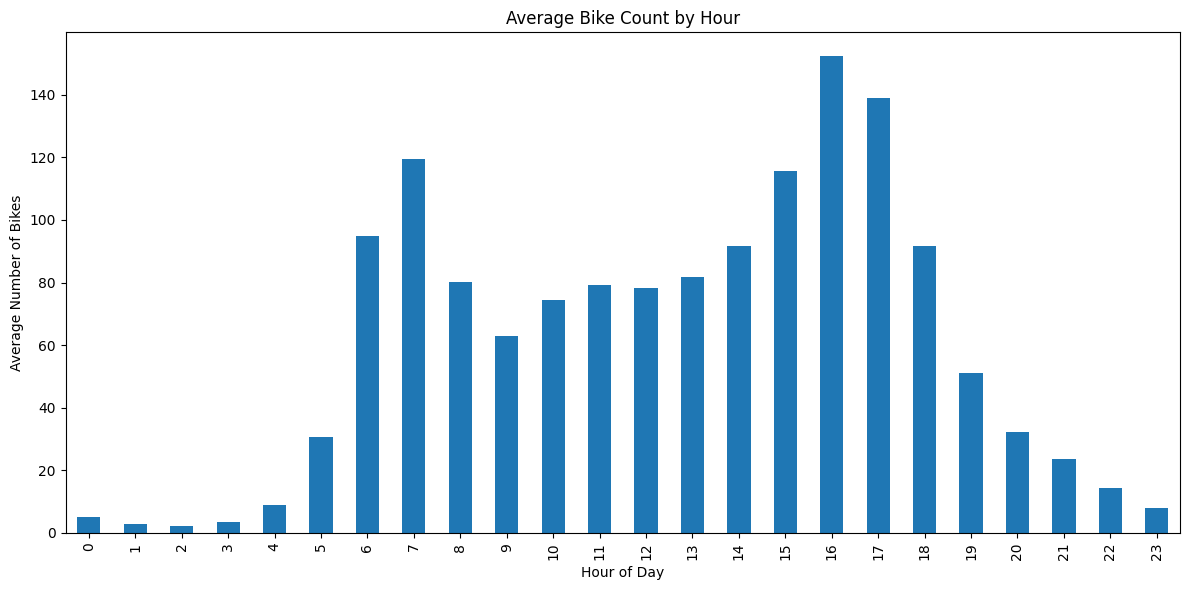

In [9]:

# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()


Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

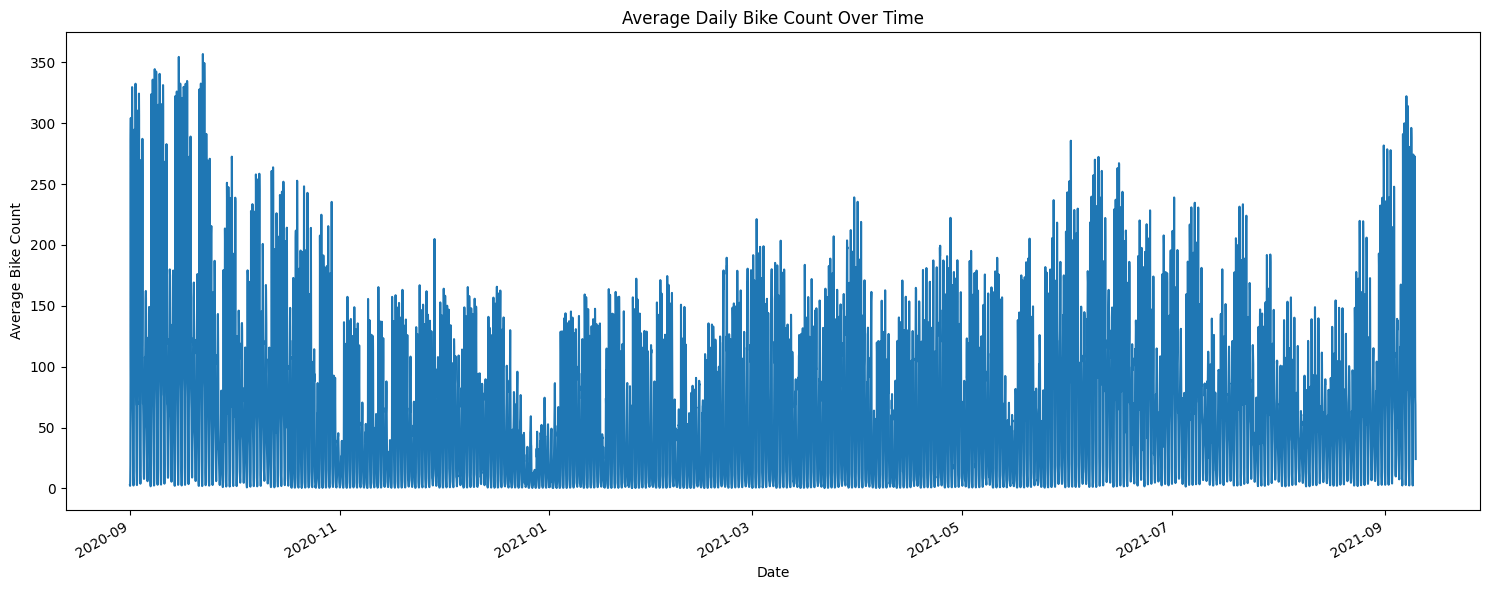

In [10]:

# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

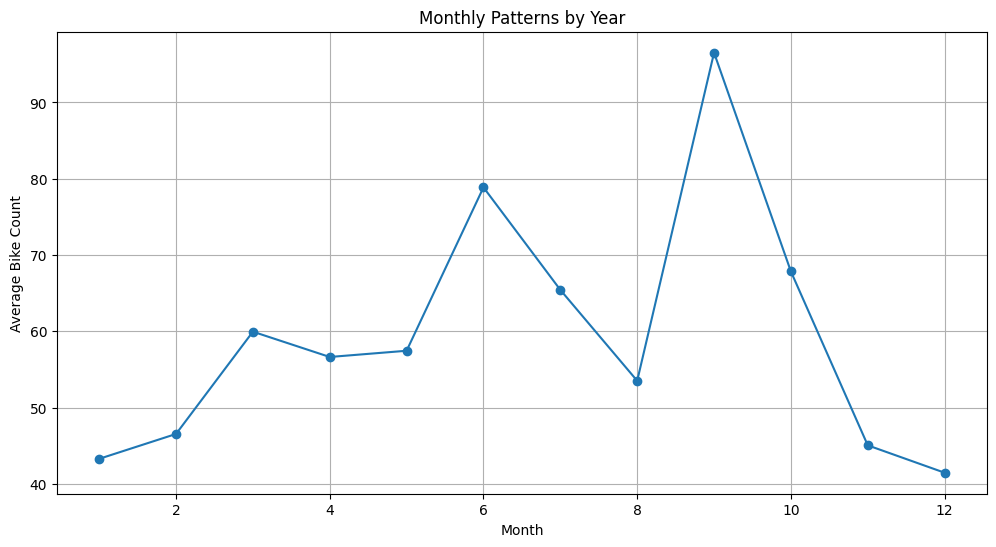

In [11]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()


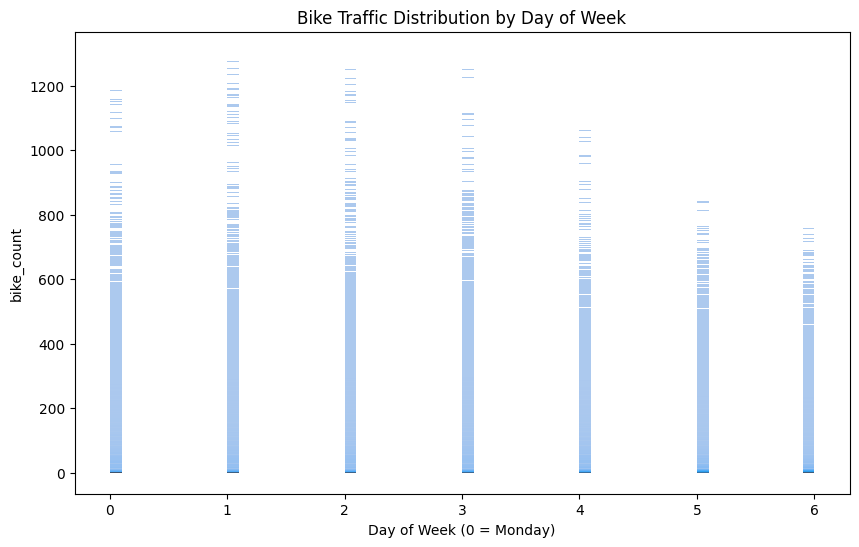

In [12]:

# 3. Weekly Patterns
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='day_of_week', y='bike_count')
plt.title('Bike Traffic Distribution by Day of Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.show()

<Figure size 1200x600 with 0 Axes>

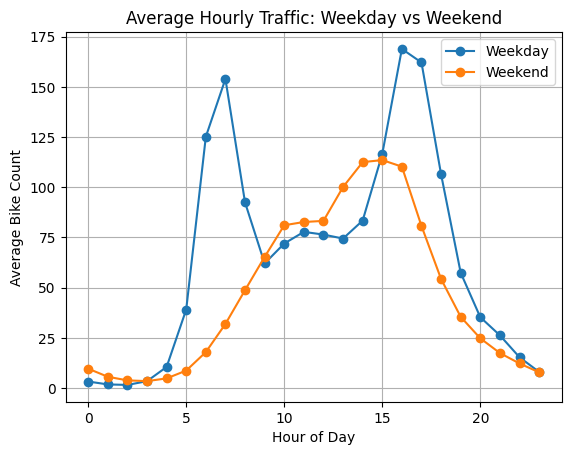

In [13]:

# 4. Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

Let's work with data.gouv API to have a quick look at my knack about the effect of holidays...

In [14]:
import requests

def get_holidays_from_api(start_year=2020, end_year=2022):
    holidays = []
    for year in range(start_year, end_year):
        url = f"https://calendrier.api.gouv.fr/jours-feries/metropole/{year}.json"
        response = requests.get(url)
        if response.status_code == 200:
            year_holidays = response.json()
            for date, name in year_holidays.items():
                holidays.append({'date': date, 'holiday_name': name})

    return pd.DataFrame(holidays)

In [15]:
holidays = get_holidays_from_api()

In [16]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.dtypes

date            datetime64[ns]
holiday_name            object
dtype: object

In [17]:
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

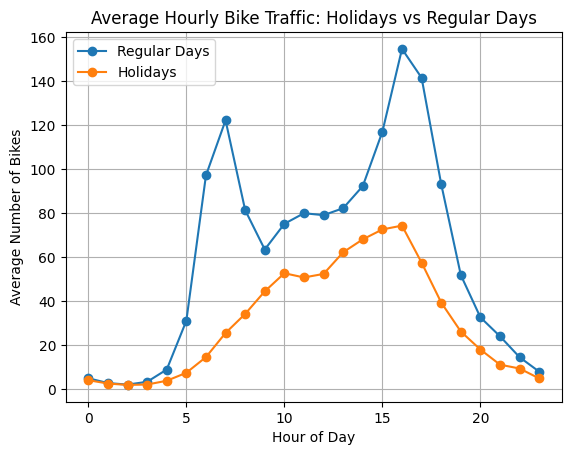

In [18]:
# 2. Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

In [19]:
# Read the holidays data
holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

# Display first few rows and basic info
print("Holidays DataFrame Info:")
print(holidays_sco.head())
print("\nDataset Info:")
print(holidays_sco.info())

Holidays DataFrame Info:
         date
0  2017-10-20
1  2017-10-21
2  2017-10-22
3  2017-10-23
4  2017-10-24

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1128 non-null   object
dtypes: object(1)
memory usage: 8.9+ KB
None


In [20]:
holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

In [21]:
holidays_sco = holidays_sco[holidays_sco['date'].dt.year == 2021]
holidays_sco = holidays_sco.drop_duplicates()
len(holidays_sco)

133

<Figure size 1500x600 with 0 Axes>

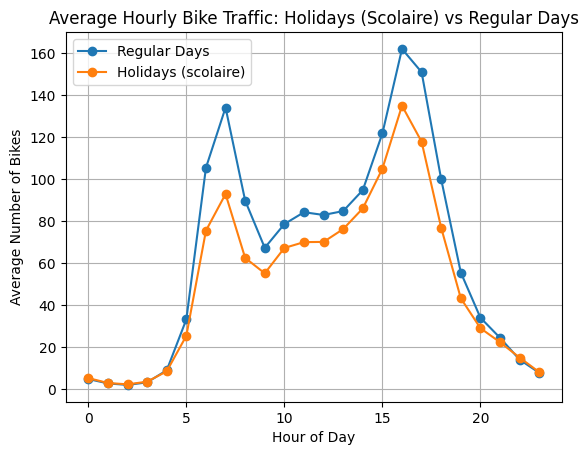

In [22]:
# 2. Compare traffic patterns vacances scolaires vs not vacances scolaires
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday_sco'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays (Scolaire) vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays (scolaire)'])
plt.grid(True)
plt.show()

Nice !! Big impact of holidays ! We will have to add it in our data set in a way (useful external data). Maybe with Zone C vacations also (but do parents use velib ?? we will have to chekc)

In [23]:
# 6. Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Choose one busy counter for decomposition
busy_counter = counter_traffic.index[0]
counter_data = df[df['counter_name'] == busy_counter].set_index('date')['bike_count']
daily_data = counter_data.resample('D').mean()

decomposition = seasonal_decompose(daily_data, period=7)  # 7 days for weekly seasonality
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

NameError: name 'counter_traffic' is not defined

Looking at this time series decomposition, we can observe several interesting patterns:

1. Observed Data (Top Plot):
- Strong weekly seasonality (regular spikes)
- Lower traffic during winter months (December-January)
- Higher traffic during summer months (June-September)
- Overall values range from about 100 to 400 bikes per day

2. Trend Component (Second Plot):
- Clear seasonal trend with lower values in winter
- Major dip in January 2021 (possibly due to COVID restrictions or weather)
- General upward trend from January to June 2021
- Values range from around 100 to 350 bikes
- Another rise starting in September

3. Seasonal Component (Third Plot):
- Very regular weekly pattern
- Amplitude of about ±60 bikes
- Consistent throughout the year, suggesting the weekly pattern is stable
- Clear weekday/weekend effect

4. Residual Component (Bottom Plot):
- Mostly random fluctuations between -50 and +50 bikes
- Some larger spikes suggesting special events or unusual days
- No obvious pattern, which is good for a decomposition

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error


In [ ]:
df

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,hour,day_of_week,month,weekday,is_weekend,is_holiday,is_holiday_sco
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2,1,9,Tuesday,False,False,False
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,3,1,9,Tuesday,False,False,False
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,4,1,9,Tuesday,False,False,False
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,15,1,9,Tuesday,False,False,False
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,18,1,9,Tuesday,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319,6,3,9,Thursday,False,False,False
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607,10,3,9,Thursday,False,False,False
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072,15,3,9,Thursday,False,False,False
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.091042,22,3,9,Thursday,False,False,False


In [ ]:

def clean_and_engineer_features(df):
    """
    Clean dataset by removing redundant columns and engineer cyclical features

    Args:
        df: pandas DataFrame containing the bike count data
    Returns:
        DataFrame with cleaned and engineered features
    """
    # Columns to drop
    columns_to_drop = [
        'counter_id',
        'site_id',
        'counter_technical_id',
        'counter_installation_date',
        'coordinates',
        'weekday',  # redundant with day_of_week
        'site_name'  # redundant with counter_name
    ]

    # Drop columns if they exist
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    df = df.drop(columns=existing_columns)

    # Add cyclical encoding for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Add cyclical encoding for month (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Add cyclical encoding for day_of_week (7-day cycle)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    return df

Research why it's useful to use cosinus to our temporal data (check the math behind)

In [ ]:
df = clean_and_engineer_features(df)
df

,counter_name,bike_count,date,latitude,longitude,log_bike_count,hour,day_of_week,month,is_weekend,is_holiday,is_holiday_sco,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
48321,28 boulevard Diderot E-O,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,9,False,False,False,0.500000,8.660254e-01,-1.0,-1.836970e-16,0.781831,0.623490
48324,28 boulevard Diderot E-O,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,9,False,False,False,0.707107,7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490
48327,28 boulevard Diderot E-O,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,9,False,False,False,0.866025,5.000000e-01,-1.0,-1.836970e-16,0.781831,0.623490
48330,28 boulevard Diderot E-O,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,9,False,False,False,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490
48333,28 boulevard Diderot E-O,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,9,False,False,False,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,254 rue de Vaugirard SO-NE,445.0,2021-09-09 06:00:00,48.839770,2.301980,6.100319,6,3,9,False,False,False,1.000000,6.123234e-17,-1.0,-1.836970e-16,0.433884,-0.900969
929178,254 rue de Vaugirard SO-NE,145.0,2021-09-09 10:00:00,48.839770,2.301980,4.983607,10,3,9,False,False,False,0.500000,-8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969
929181,254 rue de Vaugirard SO-NE,218.0,2021-09-09 15:00:00,48.839770,2.301980,5.389072,15,3,9,False,False,False,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.433884,-0.900969
929184,254 rue de Vaugirard SO-NE,21.0,2021-09-09 22:00:00,48.839770,2.301980,3.091042,22,3,9,False,False,False,-0.500000,8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969


In [ ]:
# Define feature groups
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos'
]

# Binary features don't need encoding
binary_features = [
    'is_weekend',
    'is_holiday',
    'is_holiday_sco'
]

# Categorical features need one-hot encoding
categorical_features = [
    'counter_name',
    'day_of_week'  # both cyclic and categorical representation
]

# Define preprocessing steps
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', 'passthrough', binary_features)  # Binary features pass through unchanged
    ]
)

# Create full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'hour_sin', 'hour_cos',
                                                   'month_sin', 'month_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['counter_name',
                                                   'day_of_week']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend', 'is_holiday',
                                                   'is_holiday_sco'])])),
                ('regressor', Ridge())])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Define parameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'regressor__fit_intercept': [True, False],  # Whether to fit intercept
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Different solvers
}

# Define custom scorer for RMSE
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# Create scoring dictionary
scoring = {
    'rmse': rmse_scorer,
    'r2': 'r2'
}

# Create time series split
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:

def perform_grid_search(X, y):
    """
    Perform grid search with time series cross-validation

    Args:
        X: Features DataFrame
        y: Target variable (log_bike_count)
    Returns:
        GridSearchCV object and best parameters summary
    """
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        refit='rmse',  # Use RMSE to select best model
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit GridSearchCV
    grid_search.fit(X, y)

    # Create results summary
    results = pd.DataFrame(grid_search.cv_results_)

    # Get best parameters and scores
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # Negative because of scorer
    best_r2 = results.loc[grid_search.best_index_, 'mean_test_r2']

    print("\nBest Parameters:")
    print(best_params)
    print(f"\nBest RMSE: {best_rmse:.4f}")
    print(f"Best R²: {best_r2:.4f}")

    # Create detailed results table
    summary = pd.DataFrame({
        'Parameter': list(best_params.keys()),
        'Optimal Value': list(best_params.values())
    })

    return grid_search, summary

In [ ]:
X = df[numeric_features + categorical_features + binary_features]
y = df['log_bike_count']

grid_search, summary = perform_grid_search(X, y)

# Get predictions using best model
predictions = grid_search.predict(X)

# Get feature importance (for numeric features)
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Coefficient': abs(grid_search.best_estimator_.named_steps['regressor'].coef_[:len(numeric_features)])
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters:
{'regressor__alpha': 100.0, 'regressor__fit_intercept': True, 'regressor__solver': 'auto'}

Best RMSE: 1.1585
Best R²: 0.4917


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

class RidgeFeatureAnalyzer:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco'
        ]

        self.categorical_features = [
            'counter_name',
            'day_of_week'
        ]

    def create_pipeline(self, alpha=1.0):
        """Create preprocessing and Ridge pipeline"""
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha))
        ])

    def analyze_feature_importance(self, X, y, alpha=1.0):
        """Analyze feature importance using Ridge regression"""
        # Fit pipeline
        pipeline = self.create_pipeline(alpha=alpha)
        pipeline.fit(X, y)

        # Get feature names after preprocessing
        feature_names = (
            self.numeric_features +
            pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(self.categorical_features).tolist() +
            self.binary_features
        )

        # Get coefficients
        coefficients = pipeline.named_steps['regressor'].coef_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        })

        # Sort by absolute coefficient value
        importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

        return importance_df

    def plot_feature_importance(self, importance_df, top_n=20):
        """Plot feature importance"""
        plt.figure(figsize=(12, 8))

        # Plot top N features
        top_features = importance_df.head(top_n)

        # Create bar plot
        sns.barplot(data=top_features,
                   y='feature',
                   x='coefficient',
                   palette='RdBu_r')

        plt.title(f'Top {top_n} Most Important Features (Ridge Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_feature_stability(self, X, y, alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
        """Analyze feature importance stability across different alpha values"""
        importance_results = []

        for alpha in alphas:
            importance_df = self.analyze_feature_importance(X, y, alpha=alpha)
            importance_df['alpha'] = alpha
            importance_results.append(importance_df)

        # Combine results
        stability_df = pd.concat(importance_results)

        # Plot stability
        plt.figure(figsize=(15, 10))

        # Get top 10 features by average absolute coefficient
        top_features = (stability_df.groupby('feature')['abs_coefficient']
                       .mean()
                       .sort_values(ascending=False)
                       .head(10)
                       .index)

        # Plot coefficient values across alphas for top features
        for feature in top_features:
            feature_data = stability_df[stability_df['feature'] == feature]
            plt.plot(feature_data['alpha'],
                    feature_data['coefficient'],
                    marker='o',
                    label=feature)

        plt.xscale('log')
        plt.xlabel('Alpha (log scale)')
        plt.ylabel('Coefficient Value')
        plt.title('Feature Coefficient Stability Across Different Alpha Values')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return stability_df


C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\4232779310.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features,


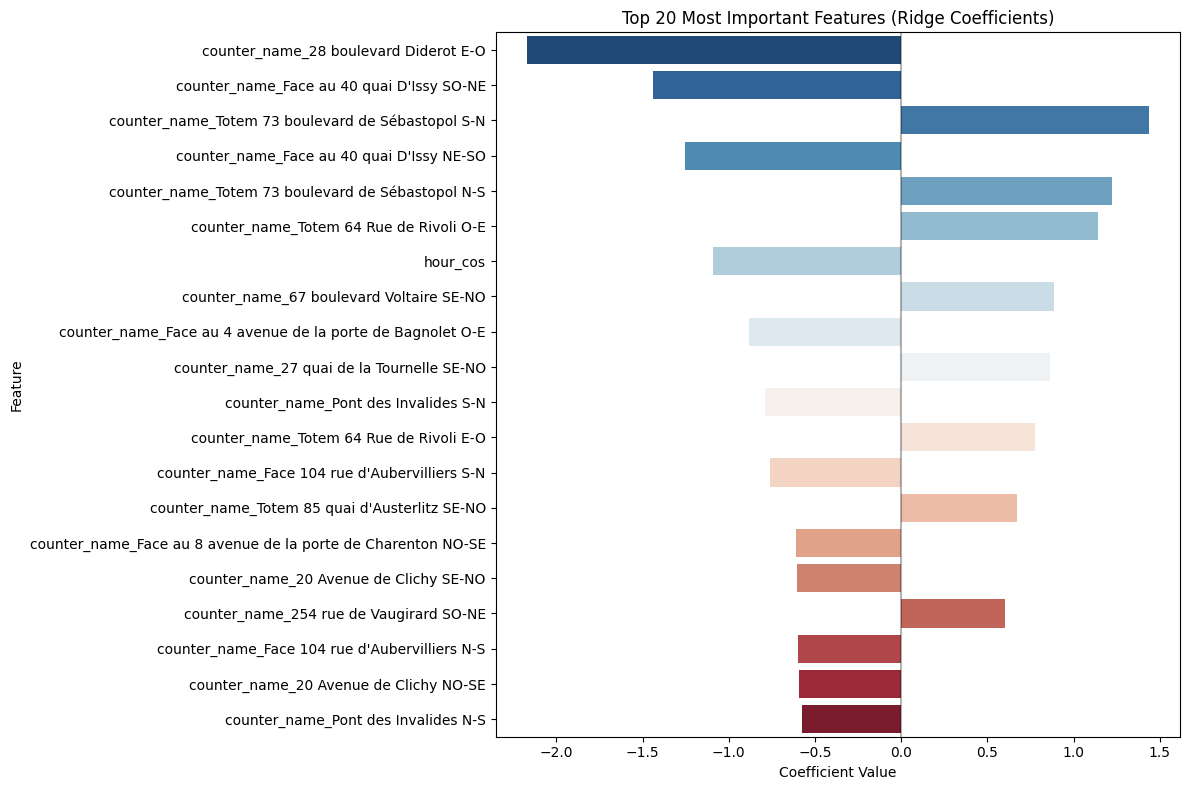

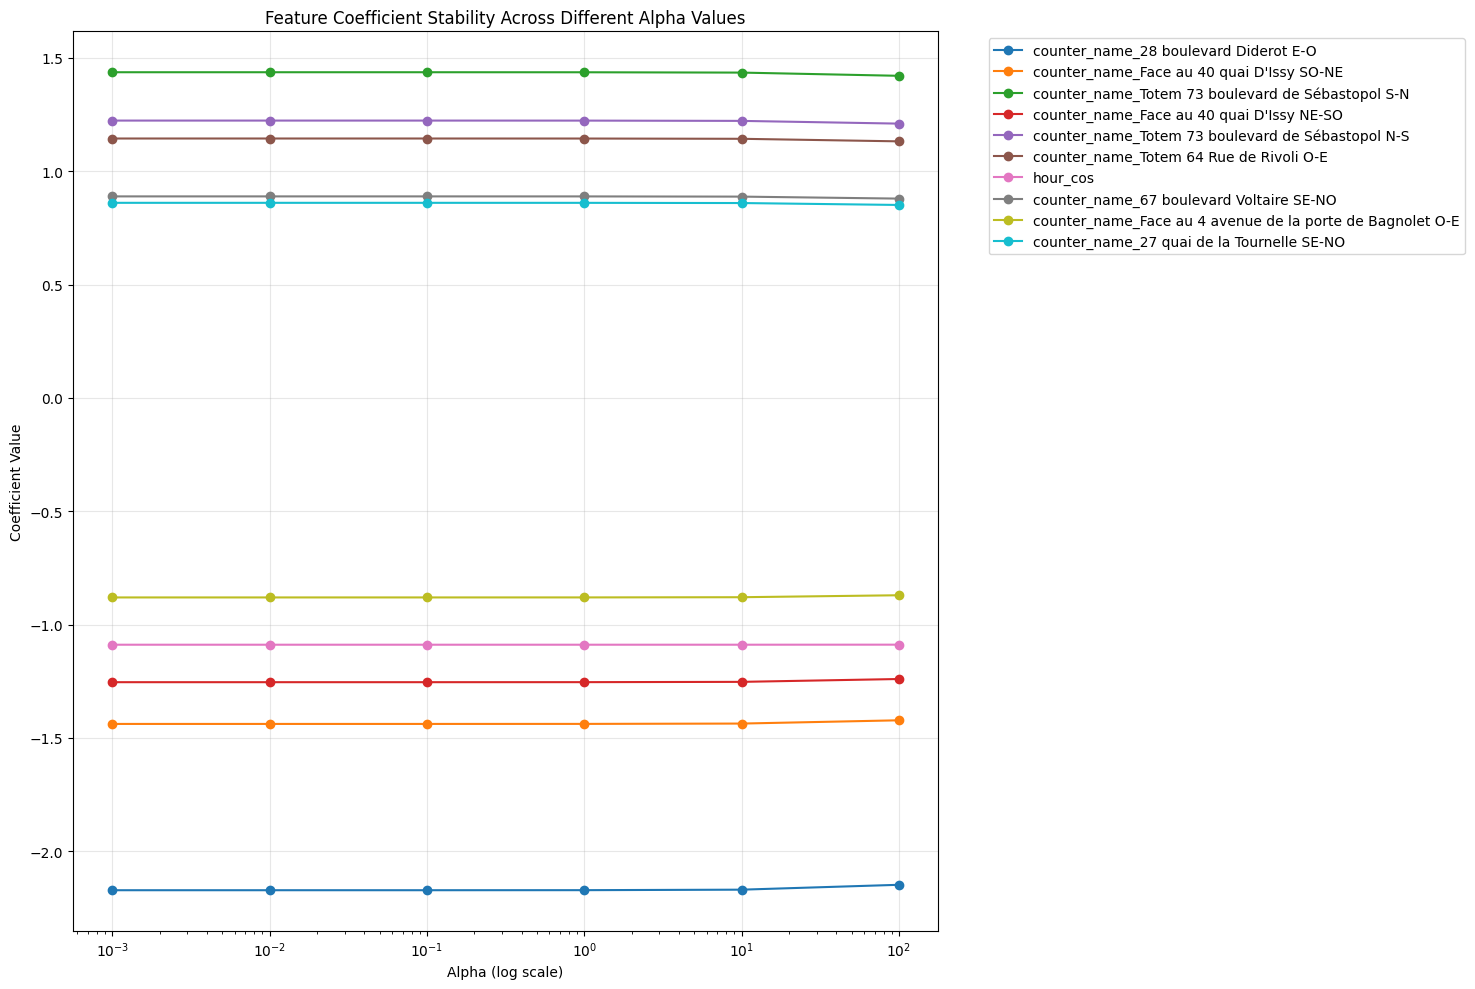


Top 10 Most Important Features (averaged across alphas):
                                                        mean       std
feature                                                               
counter_name_28 boulevard Diderot E-O               2.167648  0.009607
counter_name_Face au 40 quai D'Issy SO-NE           1.435531  0.006435
counter_name_Totem 73 boulevard de Sébastopol S-N   1.433533  0.006328
counter_name_Face au 40 quai D'Issy NE-SO           1.251746  0.005622
counter_name_Totem 73 boulevard de Sébastopol N-S   1.220696  0.005385
counter_name_Totem 64 Rue de Rivoli O-E             1.141765  0.005036
hour_cos                                            1.089004  0.000088
counter_name_67 boulevard Voltaire SE-NO            0.886930  0.003922
counter_name_Face au 4 avenue de la porte de Ba...  0.878692  0.003875
counter_name_27 quai de la Tournelle SE-NO          0.858626  0.003783


In [ ]:
X = df[numeric_features + categorical_features + binary_features]
y = df['log_bike_count']

analyzer = RidgeFeatureAnalyzer()

# Basic feature importance analysis
importance_df = analyzer.analyze_feature_importance(X, y, alpha=1.0)
analyzer.plot_feature_importance(importance_df)

# Stability analysis across different alphas
stability_df = analyzer.analyze_feature_stability(X, y)

# Print top 10 most stable features
stability_summary = (stability_df.groupby('feature')['abs_coefficient']
                    .agg(['mean', 'std'])
                    .sort_values('mean', ascending=False)
                    .head(10))
print("\nTop 10 Most Important Features (averaged across alphas):")
print(stability_summary)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

class ImprovedBikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco'
        ]

        self.categorical_features = [
            'counter_name',
            'day_of_week'
        ]

    def create_pipeline(self):
        # Add polynomial features for numeric variables
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ])

    def grid_search(self, X, y):
        # Expanded parameter grid
        param_grid = {
            'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
            'regressor__fit_intercept': [True],
            'regressor__solver': ['auto', 'svd'],
            'preprocessor__num__poly__degree': [1, 2]  # Try with and without polynomial features
        }

        # Time series split with more folds
        tscv = TimeSeriesSplit(n_splits=5, gap=24)  # gap of 24 hours

        # Create grid search
        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X, y)

        return grid_search

    def analyze_errors(self, model, X, y):
        """Analyze prediction errors to understand model weaknesses"""
        y_pred = model.predict(X)
        errors = y - y_pred

        error_analysis = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': X['hour'] if 'hour' in X.columns else None,
            'is_weekend': X['is_weekend'] if 'is_weekend' in X.columns else None
        })

        # Aggregate errors by different conditions
        analysis = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': error_analysis[error_analysis['is_weekend']]['abs_error'].mean(),
            'weekday_rmse': error_analysis[~error_analysis['is_weekend']]['abs_error'].mean(),
            'peak_hours_rmse': error_analysis[error_analysis['hour'].isin([8,9,17,18])]['abs_error'].mean(),
            'off_peak_rmse': error_analysis[~error_analysis['hour'].isin([8,9,17,18])]['abs_error'].mean()
        }

        return analysis, error_analysis

    def suggest_improvements(self, error_analysis):
        """Suggest improvements based on error analysis"""
        suggestions = []

        # Check for patterns in errors
        if error_analysis['weekend_rmse'] > error_analysis['weekday_rmse'] * 1.2:
            suggestions.append("Consider separate models for weekends")

        if error_analysis['peak_hours_rmse'] > error_analysis['off_peak_rmse'] * 1.2:
            suggestions.append("Consider separate models for peak hours")

        return suggestions


predictor = ImprovedBikePredictor()

# Perform grid search
grid_search = predictor.grid_search(X, y)

# Get best model
best_model = grid_search.best_estimator_

# Analyze errors
error_analysis, error_df = predictor.analyze_errors(best_model, X, y)

# Get improvement suggestions
suggestions = predictor.suggest_improvements(error_analysis)

print("\nError Analysis:")
for metric, value in error_analysis.items():
    print(f"{metric}: {value:.4f}")

print("\nSuggested Improvements:")
for suggestion in suggestions:
    print(f"- {suggestion}")


NameError: name 'X' is not defined

Looking at these error analysis results, let's interpret and make improvements:

The overall RMSE has improved to 0.7946 (better than previous 1.1585)
Interesting patterns in errors:


Weekend errors (0.6236) are slightly higher than weekday errors (0.5749)
We have NaN for peak_hours_rmse which suggests an issue with hour analysism

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures


class RefinedBikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco'
        ]

        self.categorical_features = [
            'counter_name'
        ]

    def analyze_predictions(self, model, X, y):
        """Detailed analysis of model predictions"""
        # Get predictions
        y_pred = model.predict(X)
        errors = y - y_pred

        # Create hour from hour_sin and hour_cos
        hours = np.round(np.arctan2(X['hour_sin'], X['hour_cos']) * 12 / np.pi % 24)

        # Create analysis DataFrame
        analysis_df = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': hours,
            'is_weekend': X['is_weekend']
        })

        # Calculate various error metrics
        error_metrics = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': np.sqrt(np.mean(analysis_df[analysis_df['is_weekend']]['error']**2)),
            'weekday_rmse': np.sqrt(np.mean(analysis_df[~analysis_df['is_weekend']]['error']**2)),
        }

        # Hourly analysis
        hourly_errors = analysis_df.groupby('hour')['abs_error'].mean()
        error_metrics['worst_hour'] = hourly_errors.idxmax()
        error_metrics['worst_hour_error'] = hourly_errors.max()
        error_metrics['best_hour'] = hourly_errors.idxmin()
        error_metrics['best_hour_error'] = hourly_errors.min()

        # Calculate errors for morning peak (7-9) and evening peak (17-19)
        morning_peak_mask = analysis_df['hour'].between(7, 9)
        evening_peak_mask = analysis_df['hour'].between(17, 19)

        error_metrics['morning_peak_rmse'] = np.sqrt(np.mean(analysis_df[morning_peak_mask]['error']**2))
        error_metrics['evening_peak_rmse'] = np.sqrt(np.mean(analysis_df[evening_peak_mask]['error']**2))

        return error_metrics, analysis_df

    def plot_error_analysis(self, analysis_df):
        """Create visualizations of prediction errors"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Error distribution
        sns.histplot(data=analysis_df, x='error', bins=50, ax=axes[0,0])
        axes[0,0].set_title('Distribution of Prediction Errors')
        axes[0,0].axvline(x=0, color='r', linestyle='--')

        # 2. Errors by hour
        hourly_errors = analysis_df.groupby('hour')['abs_error'].mean()
        sns.lineplot(data=hourly_errors, ax=axes[0,1])
        axes[0,1].set_title('Average Absolute Error by Hour')

        # 3. Actual vs Predicted
        sns.scatterplot(data=analysis_df, x='true', y='predicted', alpha=0.5, ax=axes[1,0])
        max_val = max(analysis_df['true'].max(), analysis_df['predicted'].max())
        axes[1,0].plot([0, max_val], [0, max_val], 'r--')
        axes[1,0].set_title('Actual vs Predicted Values')

        # 4. Weekend vs Weekday errors
        sns.boxplot(data=analysis_df, x='is_weekend', y='abs_error', ax=axes[1,1])
        axes[1,1].set_title('Error Distribution: Weekend vs Weekday')

        plt.tight_layout()
        return fig

    def suggest_improvements(self, error_metrics, analysis_df):
        """Generate detailed improvement suggestions based on error analysis"""
        suggestions = []

        # Analyze weekend/weekday difference
        weekend_weekday_diff = (error_metrics['weekend_rmse'] - error_metrics['weekday_rmse']) / error_metrics['weekday_rmse']
        if weekend_weekday_diff > 0.1:  # 10% difference
            suggestions.append(f"Consider separate models for weekends (RMSE {weekend_weekday_diff:.1%} higher than weekdays)")

        # Analyze peak hours
        peak_diff = (error_metrics['morning_peak_rmse'] - error_metrics['evening_peak_rmse']) / error_metrics['evening_peak_rmse']
        if abs(peak_diff) > 0.1:
            worse_peak = "morning" if peak_diff > 0 else "evening"
            suggestions.append(f"Focus on improving {worse_peak} peak predictions (RMSE {abs(peak_diff):.1%} higher)")

        # Analyze worst performing hours
        suggestions.append(f"Hour {error_metrics['worst_hour']} has highest error - consider special handling")

        # Check for systematic over/under prediction
        mean_error = analysis_df['error'].mean()
        if abs(mean_error) > 0.1:
            direction = "over-predicting" if mean_error < 0 else "under-predicting"
            suggestions.append(f"Model is systematically {direction} (mean error: {abs(mean_error):.3f})")

        return suggestions


predictor = RefinedBikePredictor()

# Create and fit model
model = predictor.create_pipeline()
model.fit(X_train, y_train)

# Analyze predictions
error_metrics, analysis_df = predictor.analyze_predictions(model, X_test, y_test)

# Print detailed metrics
print("\nDetailed Error Analysis:")
for metric, value in error_metrics.items():
    print(f"{metric}: {value:.4f}")

# Get and print suggestions
suggestions = predictor.suggest_improvements(error_metrics, analysis_df)
print("\nImprovement Suggestions:")
for suggestion in suggestions:
    print(f"- {suggestion}")

# Plot analysis
fig = predictor.plot_error_analysis(analysis_df)
plt.show()

AttributeError: 'RefinedBikePredictor' object has no attribute 'create_pipeline'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

class RefinedBikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco'
        ]

        self.categorical_features = [
            'counter_name'
        ]

    def create_pipeline(self):
        """Create preprocessing and modeling pipeline"""
        # Numeric features pipeline
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ])

        # Categorical features pipeline
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features),
                ('bin', 'passthrough', self.binary_features)
            ]
        )

        # Full pipeline
        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=100.0, fit_intercept=True))
        ])

    def grid_search(self, X, y):
        """Perform grid search for hyperparameter tuning"""
        param_grid = {
            'regressor__alpha': [1.0, 10.0, 100.0, 1000.0],
            'regressor__fit_intercept': [True],
            'preprocessor__num__poly__degree': [1, 2]
        }

        tscv = TimeSeriesSplit(n_splits=5, gap=24)

        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X, y)
        return grid_search

    def analyze_predictions(self, model, X, y):
        """Detailed analysis of model predictions"""
        # Get predictions
        y_pred = model.predict(X)
        errors = y - y_pred

        # Create hour from hour_sin and hour_cos
        hours = np.round(np.arctan2(X['hour_sin'], X['hour_cos']) * 12 / np.pi % 24)

        # Create analysis DataFrame
        analysis_df = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': hours,
            'is_weekend': X['is_weekend']
        })

        # Calculate various error metrics
        error_metrics = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': np.sqrt(np.mean(analysis_df[analysis_df['is_weekend']]['error']**2)),
            'weekday_rmse': np.sqrt(np.mean(analysis_df[~analysis_df['is_weekend']]['error']**2)),
        }

        # Hourly analysis
        hourly_errors = analysis_df.groupby('hour')['abs_error'].mean()
        error_metrics['worst_hour'] = hourly_errors.idxmax()
        error_metrics['worst_hour_error'] = hourly_errors.max()
        error_metrics['best_hour'] = hourly_errors.idxmin()
        error_metrics['best_hour_error'] = hourly_errors.min()

        # Calculate errors for morning peak (7-9) and evening peak (17-19)
        morning_peak_mask = analysis_df['hour'].between(7, 9)
        evening_peak_mask = analysis_df['hour'].between(17, 19)

        error_metrics['morning_peak_rmse'] = np.sqrt(np.mean(analysis_df[morning_peak_mask]['error']**2))
        error_metrics['evening_peak_rmse'] = np.sqrt(np.mean(analysis_df[evening_peak_mask]['error']**2))

        return error_metrics, analysis_df

    def plot_error_analysis(self, analysis_df):
        """Create visualizations of prediction errors"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Error distribution
        sns.histplot(data=analysis_df, x='error', bins=50, ax=axes[0,0])
        axes[0,0].set_title('Distribution of Prediction Errors')
        axes[0,0].axvline(x=0, color='r', linestyle='--')

        # 2. Errors by hour
        hourly_errors = analysis_df.groupby('hour')['abs_error'].mean()
        sns.lineplot(data=hourly_errors, ax=axes[0,1])
        axes[0,1].set_title('Average Absolute Error by Hour')

        # 3. Actual vs Predicted
        sns.scatterplot(data=analysis_df, x='true', y='predicted', alpha=0.5, ax=axes[1,0])
        max_val = max(analysis_df['true'].max(), analysis_df['predicted'].max())
        axes[1,0].plot([0, max_val], [0, max_val], 'r--')
        axes[1,0].set_title('Actual vs Predicted Values')

        # 4. Weekend vs Weekday errors
        sns.boxplot(data=analysis_df, x='is_weekend', y='abs_error', ax=axes[1,1])
        axes[1,1].set_title('Error Distribution: Weekend vs Weekday')

        plt.tight_layout()
        return fig

    def suggest_improvements(self, error_metrics, analysis_df):
        """Generate detailed improvement suggestions based on error analysis"""
        suggestions = []

        # Analyze weekend/weekday difference
        weekend_weekday_diff = (error_metrics['weekend_rmse'] - error_metrics['weekday_rmse']) / error_metrics['weekday_rmse']
        if weekend_weekday_diff > 0.1:
            suggestions.append(f"Consider separate models for weekends (RMSE {weekend_weekday_diff:.1%} higher than weekdays)")

        # Analyze peak hours
        peak_diff = (error_metrics['morning_peak_rmse'] - error_metrics['evening_peak_rmse']) / error_metrics['evening_peak_rmse']
        if abs(peak_diff) > 0.1:
            worse_peak = "morning" if peak_diff > 0 else "evening"
            suggestions.append(f"Focus on improving {worse_peak} peak predictions (RMSE {abs(peak_diff):.1%} higher)")

        # Analyze worst performing hours
        suggestions.append(f"Hour {error_metrics['worst_hour']} has highest error - consider special handling")

        # Check for systematic over/under prediction
        mean_error = analysis_df['error'].mean()
        if abs(mean_error) > 0.1:
            direction = "over-predicting" if mean_error < 0 else "under-predicting"
            suggestions.append(f"Model is systematically {direction} (mean error: {abs(mean_error):.3f})")

        return suggestions


Running grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters:
{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0, 'regressor__fit_intercept': True}

Best RMSE: 0.7966

Detailed Error Analysis:
overall_rmse: 0.7916
weekend_rmse: 0.8279
weekday_rmse: 0.7767
worst_hour: 6.0000
worst_hour_error: 0.9267
best_hour: 11.0000
best_hour_error: 0.4030
morning_peak_rmse: 0.8274
evening_peak_rmse: 0.7581

Improvement Suggestions:
- Hour 6.0 has highest error - consider special handling


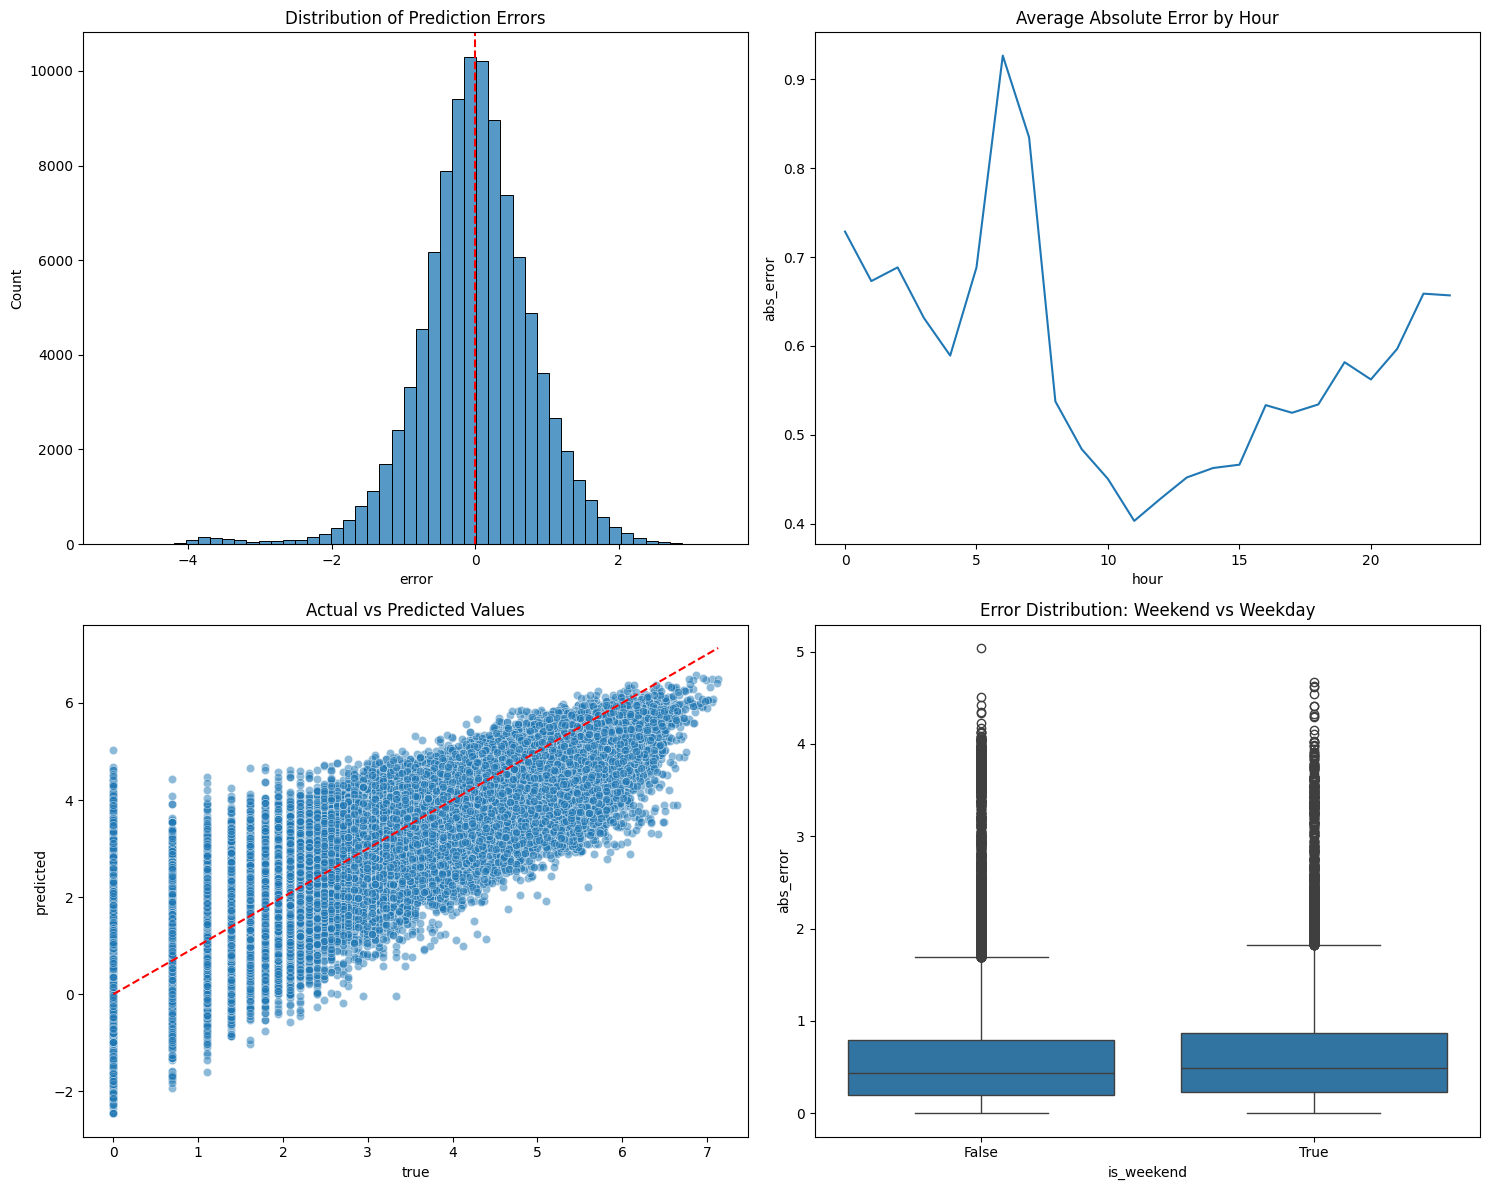

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your latest data is in a DataFrame called 'df'
def run_complete_analysis(df):
    """Run complete analysis on bike prediction data"""

    # 1. Prepare the data
    # Features we want to use
    feature_columns = [
        'latitude', 'longitude', 'hour_sin', 'hour_cos',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'is_weekend', 'is_holiday', 'is_holiday_sco', 'counter_name'
    ]

    # Target variable
    target = 'log_bike_count'

    # Split the data - using 20% for testing
    X = df[feature_columns]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 2. Initialize and run the predictor
    predictor = RefinedBikePredictor()

    # 3. Run grid search
    print("Running grid search...")
    grid_search = predictor.grid_search(X_train, y_train)

    print("\nBest Parameters:")
    print(grid_search.best_params_)
    print(f"\nBest RMSE: {-grid_search.best_score_:.4f}")  # Negative because of scorer

    # 4. Get best model and analyze predictions
    best_model = grid_search.best_estimator_
    error_metrics, analysis_df = predictor.analyze_predictions(best_model, X_test, y_test)

    # 5. Print detailed metrics
    print("\nDetailed Error Analysis:")
    for metric, value in error_metrics.items():
        print(f"{metric}: {value:.4f}")

    # 6. Get and print suggestions
    suggestions = predictor.suggest_improvements(error_metrics, analysis_df)
    print("\nImprovement Suggestions:")
    for suggestion in suggestions:
        print(f"- {suggestion}")

    # 7. Create and show plots
    fig = predictor.plot_error_analysis(analysis_df)

    return {
        'best_model': best_model,
        'error_metrics': error_metrics,
        'analysis_df': analysis_df,
        'figure': fig
    }

# Run the analysis
results = run_complete_analysis(df)  # Replace df with your DataFrame

# Access results
best_model = results['best_model']
error_metrics = results['error_metrics']
analysis_df = results['analysis_df']

Let's work with some weather data a bit, see if it improves the model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

class WeatherPreprocessor:
    def __init__(self):
        # Most relevant weather features for bike usage
        self.primary_weather_features = [
            't',       # temperature (K)
            'ff',      # wind speed
            'u',       # humidity
            'vv',      # visibility
            'rr1',     # precipitation last hour
            'rr24',    # precipitation last 24h
            'pres',    # pressure
        ]

    def clean_weather_data(self, weather_df):
        """Clean and preprocess weather data"""
        df = weather_df.copy()

        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'])

        # Convert temperature from Kelvin to Celsius
        df['temperature'] = df['t'] - 273.15

        # Clean and rename key features
        weather_features = {
            'temperature': df['temperature'],
            'wind_speed': df['ff'],
            'humidity': df['u'],
            'visibility': df['vv'],
            'precipitation_1h': df['rr1'].fillna(0),
            'precipitation_24h': df['rr24'].fillna(0),
            'pressure': df['pres']
        }

        # Create cleaned dataframe
        clean_df = pd.DataFrame(weather_features)
        clean_df['date'] = df['date']

        # Add derived features
        clean_df['is_rain'] = clean_df['precipitation_1h'] > 0
        clean_df['is_heavy_rain'] = clean_df['precipitation_1h'] > 5

        # Create comfort index (simplified version of feels-like temperature)
        clean_df['comfort_index'] = (
            clean_df['temperature'] -
            0.3 * clean_df['wind_speed'] +
            0.2 * (clean_df['humidity'] - 65)
        )

        return clean_df

    def merge_with_bike_data(self, bike_df, weather_df):
        """Merge weather data with bike count data"""
        # Clean weather data first
        clean_weather = self.clean_weather_data(weather_df)

        # Round both datetime columns to hours for merging
        bike_df = bike_df.copy()
        bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('H')
        clean_weather['date'] = clean_weather['date'].dt.floor('H')

        # Merge datasets
        merged_df = pd.merge(
            bike_df,
            clean_weather,
            on='date',
            how='left'
        )

        # Forward fill any missing weather data (use previous hour's weather)
        weather_columns = clean_weather.columns.drop('date')
        merged_df[weather_columns] = merged_df[weather_columns].fillna(method='ffill')

        return merged_df

    def add_weather_indicators(self, df):
        """Add weather condition indicators"""
        df = df.copy()

        # Temperature ranges
        df['temp_category'] = pd.cut(
            df['temperature'],
            bins=[-np.inf, 5, 15, 25, np.inf],
            labels=['cold', 'cool', 'moderate', 'warm']
        )

        # Weather conditions
        df['is_good_weather'] = (
            (df['temperature'].between(15, 25)) &
            (df['precipitation_1h'] == 0) &
            (df['wind_speed'] < 20) &
            (df['visibility'] > 1000)
        )

        return df

def prepare_features_with_weather(bike_df, weather_df):
    """Prepare complete feature set with weather data"""
    # Initialize preprocessor
    preprocessor = WeatherPreprocessor()

    # Merge and preprocess data
    merged_df = preprocessor.merge_with_bike_data(bike_df, weather_df)

    # Add weather indicators
    final_df = preprocessor.add_weather_indicators(merged_df)

    # Select features for modeling
    weather_features = [
        'temperature',
        'wind_speed',
        'humidity',
        'visibility',
        'precipitation_1h',
        'comfort_index',
        'is_rain',
        'is_good_weather'
    ]

    return final_df, weather_features

C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:63: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('H')
C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  clean_weather['date'] = clean_weather['date'].dt.floor('H')
C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[weather_columns] = merged_df[weather_columns].fillna(method='ffill')


Running grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters:
{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0, 'regressor__fit_intercept': True}

Best RMSE: 0.7960

Detailed Error Analysis:
overall_rmse: 0.7933
weekend_rmse: 0.8299
weekday_rmse: 0.7783
worst_hour: 6.0000
worst_hour_error: 0.9309
best_hour: 11.0000
best_hour_error: 0.3943
morning_peak_rmse: 0.8459
evening_peak_rmse: 0.7803

Improvement Suggestions:
- Hour 6.0 has highest error - consider special handling


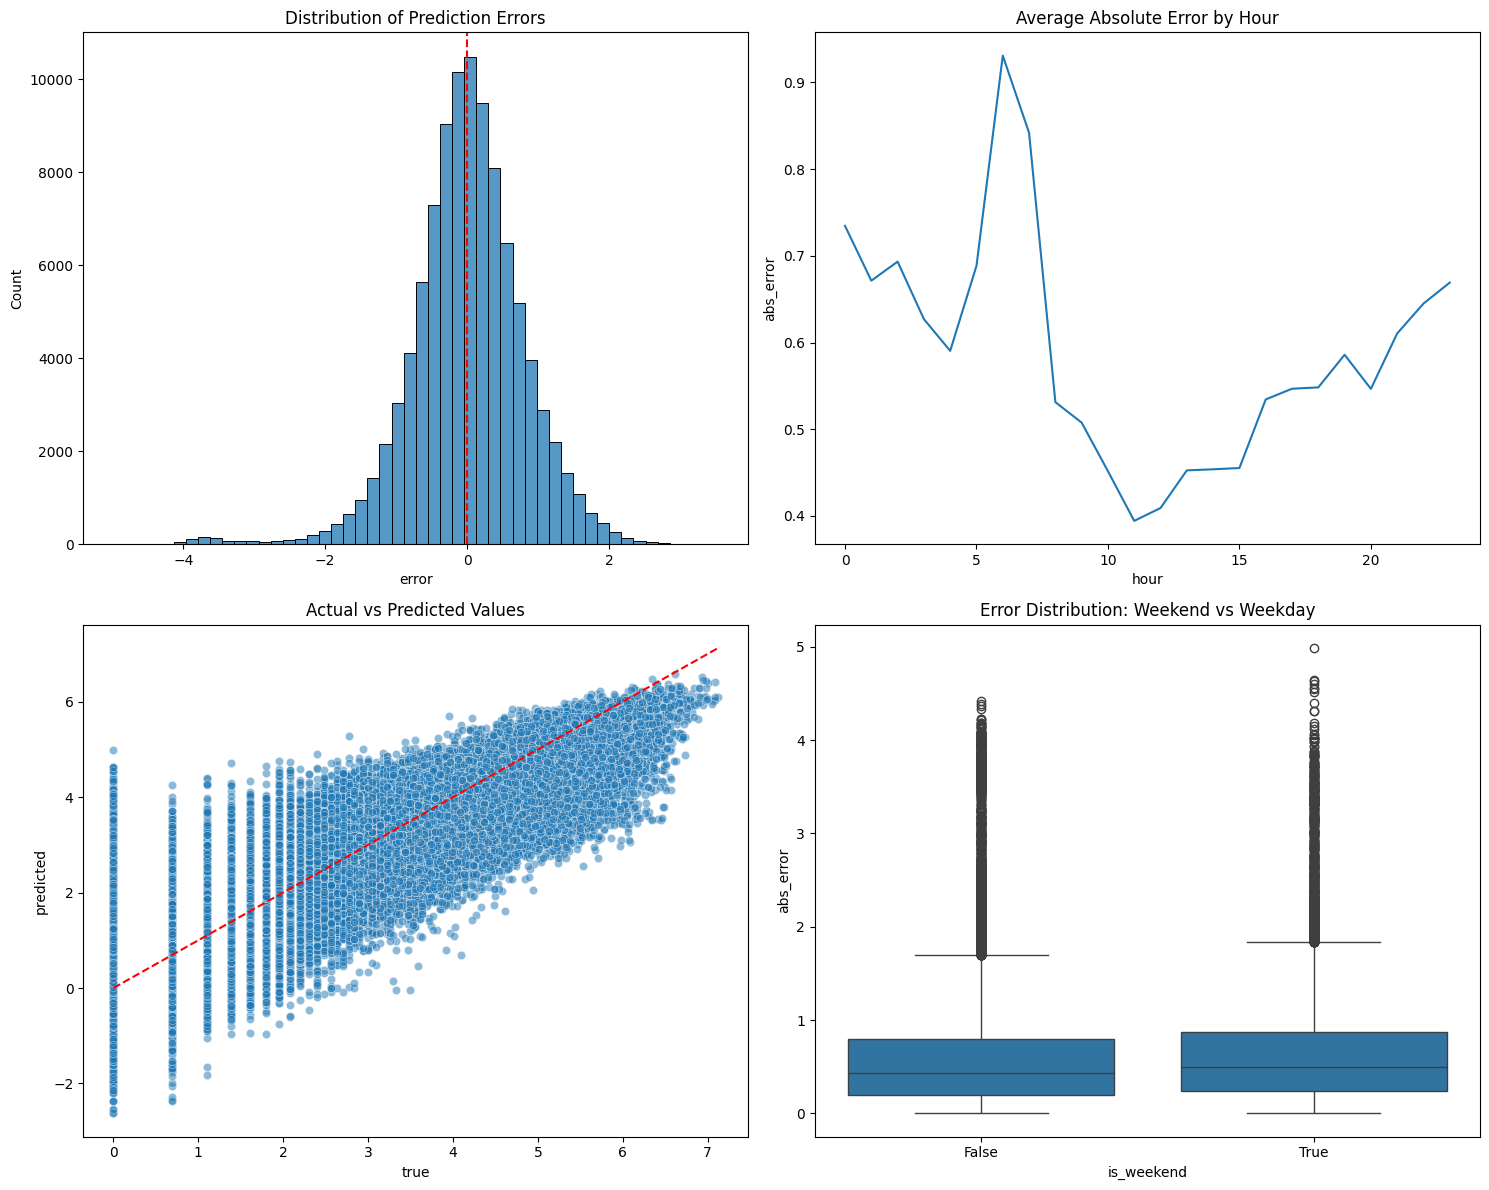

In [ ]:
# Example usage:

bike_df = df
weather_df = pd.read_csv('external_data/Weather/external_data.csv')

# Prepare features
final_df, weather_features = prepare_features_with_weather(bike_df, weather_df)

# Add weather features to your existing feature list
all_features = numeric_features + categorical_features + binary_features + weather_features

# Update your model
predictor = RefinedBikePredictor()
results = run_complete_analysis(final_df[all_features + ['log_bike_count']])

In [ ]:
final_df

,counter_name,bike_count,date,latitude,longitude,log_bike_count,hour,day_of_week,month,is_weekend,...,humidity,visibility,precipitation_1h,precipitation_24h,pressure,is_rain,is_heavy_rain,comfort_index,temp_category,is_good_weather
0,28 boulevard Diderot E-O,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,9,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,28 boulevard Diderot E-O,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,9,False,...,88.0,25000.0,0.0,0.0,100900.0,False,False,15.07,cool,False
2,28 boulevard Diderot E-O,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,9,False,...,88.0,25000.0,0.0,0.0,100900.0,False,False,15.07,cool,False
3,28 boulevard Diderot E-O,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,9,False,...,41.0,30000.0,0.0,0.0,100690.0,False,False,14.50,moderate,True
4,28 boulevard Diderot E-O,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,9,False,...,47.0,30000.0,0.0,0.0,100700.0,False,False,14.50,moderate,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496876,254 rue de Vaugirard SO-NE,445.0,2021-09-09 06:00:00,48.839770,2.301980,6.100319,6,3,9,False,...,95.0,5000.0,0.0,1.2,100080.0,False,False,25.01,moderate,True
496877,254 rue de Vaugirard SO-NE,145.0,2021-09-09 10:00:00,48.839770,2.301980,4.983607,10,3,9,False,...,95.0,5000.0,0.0,1.2,100080.0,False,False,25.01,moderate,True
496878,254 rue de Vaugirard SO-NE,218.0,2021-09-09 15:00:00,48.839770,2.301980,5.389072,15,3,9,False,...,51.0,20000.0,0.0,1.2,100050.0,False,False,21.75,warm,False
496879,254 rue de Vaugirard SO-NE,21.0,2021-09-09 22:00:00,48.839770,2.301980,3.091042,22,3,9,False,...,51.0,20000.0,0.0,1.2,100050.0,False,False,21.75,warm,False


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Define features based on actual columns
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'humidity',
    'visibility',
    'precipitation_1h',
    'comfort_index'
]

binary_features = [
    'is_weekend',
    'is_holiday',
    'is_heavy_rain',
    'is_good_weather'
]

categorical_features = [
    'counter_name',
    'temp_category'
]

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', 'passthrough', binary_features)
])

# Create RandomForest pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    ))
])

def evaluate_model(model, X, y):
    """Evaluate model using time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        # Get train/val sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Drop rows with NaN values
        mask_train = ~X_train.isna().any(axis=1)
        mask_val = ~X_val.isna().any(axis=1)

        X_train_clean = X_train[mask_train]
        y_train_clean = y_train[mask_train]
        X_val_clean = X_val[mask_val]
        y_val_clean = y_val[mask_val]

        print(f"\nFold {fold+1}:")
        print(f"Training samples: {len(X_train_clean)}")
        print(f"Validation samples: {len(X_val_clean)}")

        # Fit and predict
        model.fit(X_train_clean, y_train_clean)
        y_pred = model.predict(X_val_clean)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_val_clean - y_pred) ** 2))
        rmse_scores.append(rmse)

        print(f"Fold RMSE: {rmse:.4f}")

    print(f"\nMean RMSE: {np.mean(rmse_scores):.4f}")
    return model, np.mean(rmse_scores)

In [ ]:
# First check which features are actually available and not all NaN
def check_features(df, feature_list):
    available = []
    for feature in feature_list:
        if feature in df.columns and not df[feature].isna().all():
            available.append(feature)
    return available